In [1]:
import numpy as np
import librosa
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers, models

In [2]:
def extract_mfcc(y, sr=16000, n_mfcc=13, dct_type=2, norm='ortho', lifter=0, n_fft=2048, hop_length=512, n_mels=128, fmax=12800):

    """
    :param y: audio time series
    :param sr: sample rate
    :param n_mfcc: number of MFCC coefficients (excluding the 0th coefficient)
    :param dct_type: type of DCT used - 1 or 2 (default 2)
    :param norm: normalization technique - None or 'ortho' (default 'ortho')
    :param lifter: apply liftering to final MFCC coefficients (default 0)
    :param n_fft: length of the FFT window (default 2048)
    :param hop_length: number of samples between successive frames (default 512)
    :param n_mels: number of Mel bands to generate (default 128)
    :param fmax: highest frequency (in Hz) (default 16000)
    :return: MFCC coefficients (including the 0th coefficient)
    """
    mfcc_feat = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, dct_type=dct_type, norm=norm, lifter=lifter,
                                     n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax, fmin=25)

    # Convert to decibel scale and add the 0th coefficient (log energy)
    mfcc_feat = librosa.power_to_db(mfcc_feat, ref=np.max)
    mfcc_feat = np.vstack((mfcc_feat, np.mean(mfcc_feat, axis=0)))
    
    return mfcc_feat

In [3]:
# 設定音頻片段的路徑
audio_path = 'segmented_audio'
# 初始化特徵列表
features = []

# 迭代處理每個音頻片段
for filename in tqdm(os.listdir(audio_path)):
    if filename.endswith('.wav'):
        # 加載音頻片段
        y, sr = librosa.load(os.path.join(audio_path, filename), sr=None)
        
        # 提取MFCC特徵
        mfccs = extract_mfcc(y, sr=sr, n_mfcc=13, dct_type=2, norm='ortho', lifter=0, n_fft=2048, hop_length=512, n_mels=128, fmax=12800)
        
        # 計算每個MFCC係數的均值
        mfccs_mean = np.mean(mfccs, axis=1)
        
        # 將特徵加入列表
        features.append(mfccs_mean)

# 將特徵列表轉換成numpy數組
features = np.array(features)

100%|██████████| 24538/24538 [04:06<00:00, 99.54it/s] 


In [4]:
features.shape

(24538, 14)

In [ ]:
# plot features

In [5]:
features[0]

array([-80.      , -16.87869 , -32.84374 , -72.287766, -78.57085 ,
       -79.646   , -80.      , -80.      , -80.      , -80.      ,
       -80.      , -79.67985 , -79.28595 , -70.707146], dtype=float32)

# 標準化特徵

In [6]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# 執行PCA分析

In [17]:
pca = PCA(n_components=3) # 設定PCA的主成分數量
principal_components = pca.fit_transform(features_scaled)

# 顯示PCA結果

In [18]:
print(principal_components)

[[-1.7275416   1.8332434  -0.9496055 ]
 [-0.04270763 -0.8296599   0.5106256 ]
 [-0.8891513  -0.7802065   0.9995494 ]
 ...
 [ 4.860272    2.5149488   1.3711419 ]
 [ 2.2198062   2.2947078   0.9131996 ]
 [ 1.6309729   0.7390047   1.5860622 ]]


# 繪製PCA結果

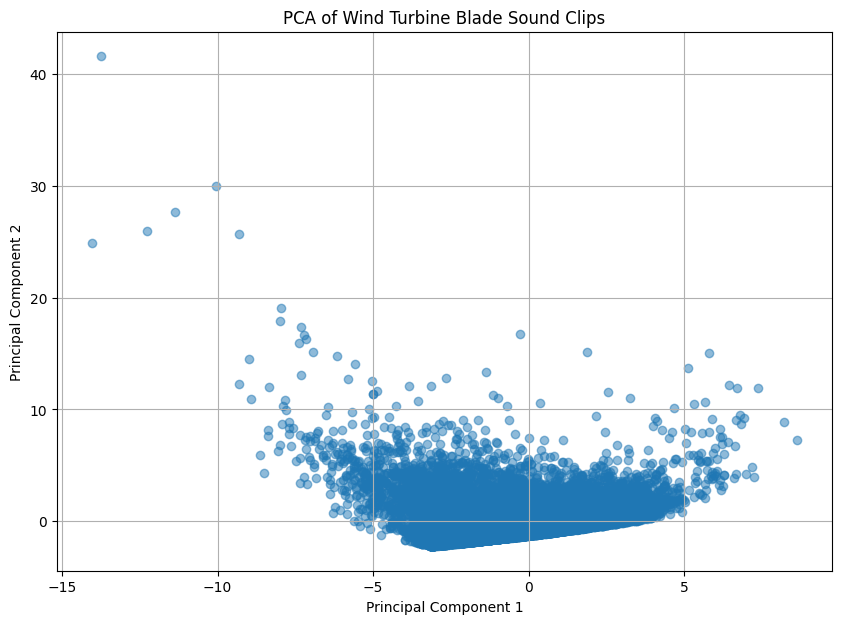

In [19]:
plt.figure(figsize=(10, 7))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.title('PCA of Wind Turbine Blade Sound Clips')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.savefig('pca.png')
plt.show()

# 定義自動編碼器模型

In [20]:
# 定義自動編碼器模型
input_dim = features_scaled.shape[1]

autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')

# 打印模型摘要
autoencoder.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               3840      
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dense_17 (Dense)            (None, 128)               8320      
                                                                 
 dense_18 (Dense)            (None, 256)              

In [21]:
train_features, test_features = train_test_split(features_scaled, test_size=0.2, random_state=42)

# 訓練自動編碼器

In [22]:
history = autoencoder.fit(train_features, train_features, 
                          epochs=200, 
                          batch_size=32, 
                          validation_split=0.2)

Epoch 1/200
491/491 [==============================] - 2s 3ms/step - loss: 0.7621 - val_loss: 0.7212
Epoch 2/200
491/491 [==============================] - 1s 3ms/step - loss: 0.6579 - val_loss: 0.6853
Epoch 3/200
491/491 [==============================] - 1s 3ms/step - loss: 0.6482 - val_loss: 0.6862
Epoch 4/200
491/491 [==============================] - 1s 3ms/step - loss: 0.6420 - val_loss: 0.6769
Epoch 5/200
491/491 [==============================] - 1s 3ms/step - loss: 0.6397 - val_loss: 0.6736
Epoch 6/200
491/491 [==============================] - 1s 3ms/step - loss: 0.6374 - val_loss: 0.6746
Epoch 7/200
491/491 [==============================] - 1s 3ms/step - loss: 0.6374 - val_loss: 0.6768
Epoch 8/200
491/491 [==============================] - 1s 3ms/step - loss: 0.6379 - val_loss: 0.6718
Epoch 9/200
491/491 [==============================] - 1s 3ms/step - loss: 0.6359 - val_loss: 0.6740
Epoch 10/200
491/491 [==============================] - 1s 3ms/step - loss: 0.6356 - val_lo

KeyboardInterrupt: 

# 評估自動編碼器

In [ ]:
# 繪製訓練過程中的損失變化
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# 使用自動編碼器進行異常檢測

In [ ]:
# 計算重建誤差
reconstructions = autoencoder.predict(test_features)
reconstruction_errors = np.mean((test_features - reconstructions) ** 2, axis=1)

# 設置異常檢測閾值
threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)

# 標記異常樣本
anomalies = reconstruction_errors > threshold

print(f'Number of anomalies detected: {np.sum(anomalies)}')